In [1]:
## Import needed libraries
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import pylab   as plt

In [2]:
# hSBM specific libraries
from sbmtm import sbmtm
import graph_tool.all as gt

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
file = open('hSBM_demogr_model.pickle', 'rb')
model = pickle.load(file)

In [7]:
# The hierarchical levels themselves are represented by individual BlockState() instances
levels = model.state.get_levels()
for s in levels:
    print(s)
    if s.get_N() == 1:
        break

<BlockState object with 38424 blocks (10 nonempty), degree-corrected, for graph <Graph object, undirected, with 38424 vertices and 73993 edges, 2 internal vertex properties, at 0x7f5ff862cdf0>, at 0x7f601859e1c0>
<BlockState object with 8 blocks (5 nonempty), for graph <Graph object, undirected, with 38424 vertices and 14 edges, at 0x7f601859eca0>, at 0x7f6013f7f250>
<BlockState object with 4 blocks (2 nonempty), for graph <Graph object, undirected, with 8 vertices and 5 edges, at 0x7f6013f7fcd0>, at 0x7f6013f7fa60>
<BlockState object with 2 blocks (1 nonempty), for graph <Graph object, undirected, with 4 vertices and 1 edge, at 0x7f6013f07ac0>, at 0x7f6013f7f3a0>


In [8]:
state = model.state
state_0 = state.get_levels()[0]
matrix = gt.adjacency(g=state_0.get_bg(),weight=state_0.get_ers()).T
graph = gt.generate_sbm(b=state_0.b.a, probs=matrix, 
                            out_degs=state_0.g.degree_property_map("total").a,
                            in_degs=state_0.g.degree_property_map("total").a,
                            directed=False)
new_state = gt.minimize_nested_blockmodel_dl(graph,
                                             state_args=dict(base_type=gt.BlockState, **{'clabel': state_0.g.vp['kind'], 'pclabel': state_0.g.vp['kind']}),
                                             multilevel_mcmc_args=dict(verbose=False))

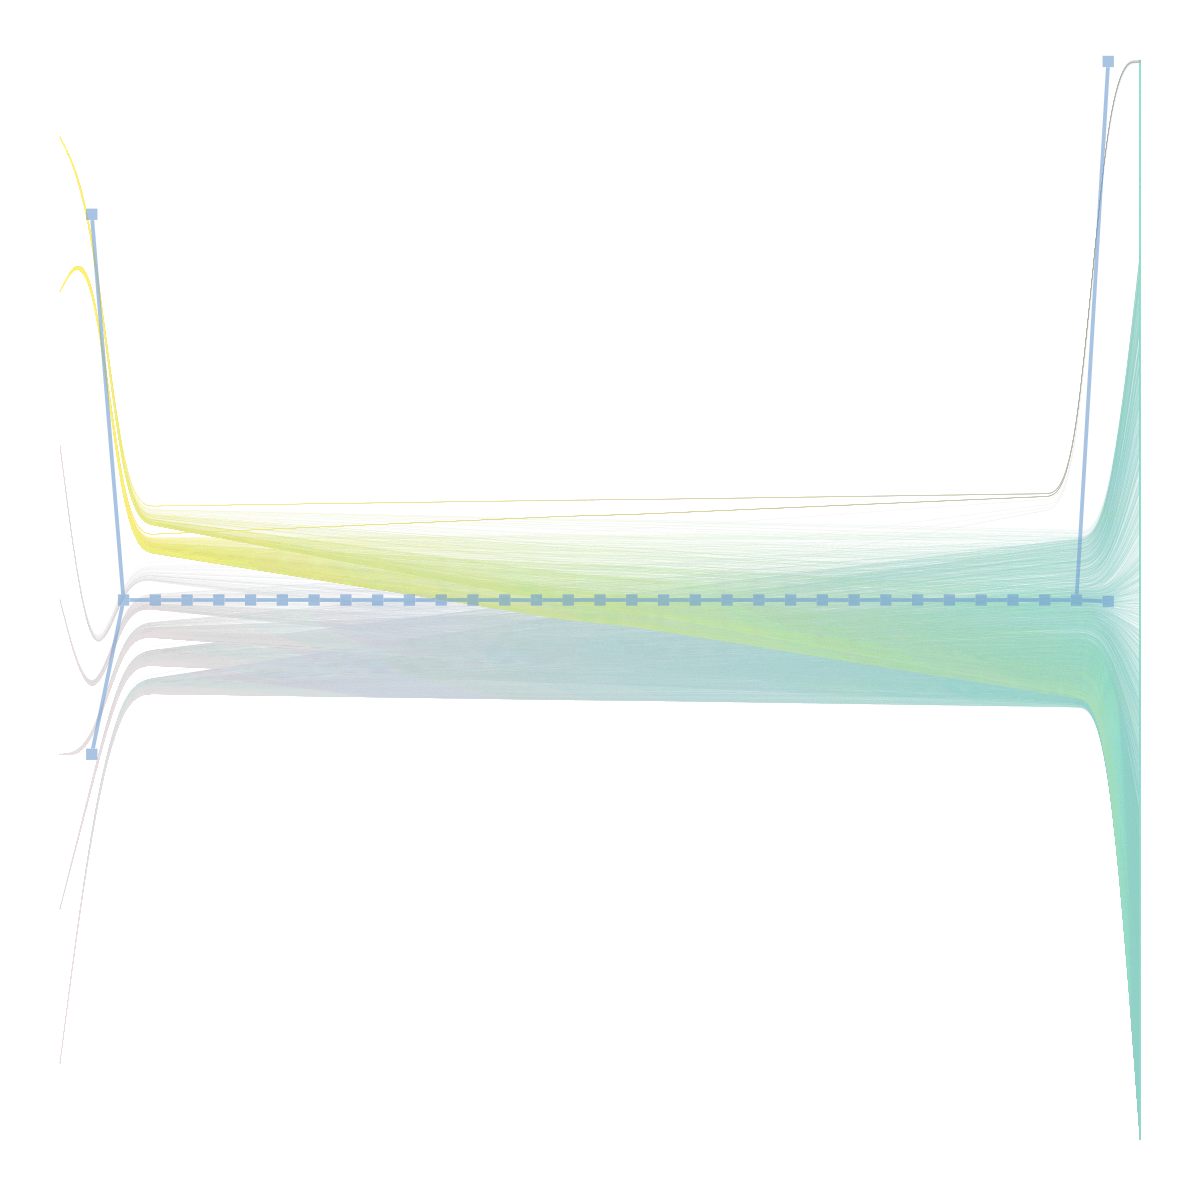

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f6018c5ed90, at 0x7f6013cb6220>,
 <GraphView object, directed, with 38459 vertices and 38458 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f603c4ff760, at 0x7f60184c8fa0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f603c4ff760, at 0x7f60184b24f0>, False), at 0x7f603c4ff760>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f603c4ff760, at 0x7f6013f8d130>)

In [11]:
new_state.draw(layout="bipartite",subsample_edges=6000,bip_aspect=1, hvertex_size=8, hedge_pen_width=1.9, output_size=(600, 600))

In [14]:
for i_n_init in range(10):
    base_type = gt.BlockState
    state_tmp = gt.minimize_nested_blockmodel_dl(graph,
                                                state_args=dict(
                                                    base_type=base_type,
                                                    **{'clabel': state_0.g.vp['kind'], 'pclabel': state_0.g.vp['kind']}),
                                                multilevel_mcmc_args=dict(
                                                    verbose=False))
    L = 0
    for s in state_tmp.levels:
        L += 1
        if s.get_nonempty_B() == 2:
            break
    state_tmp = state_tmp.copy(bs=state_tmp.get_bs()[:L] + [np.zeros(1)])

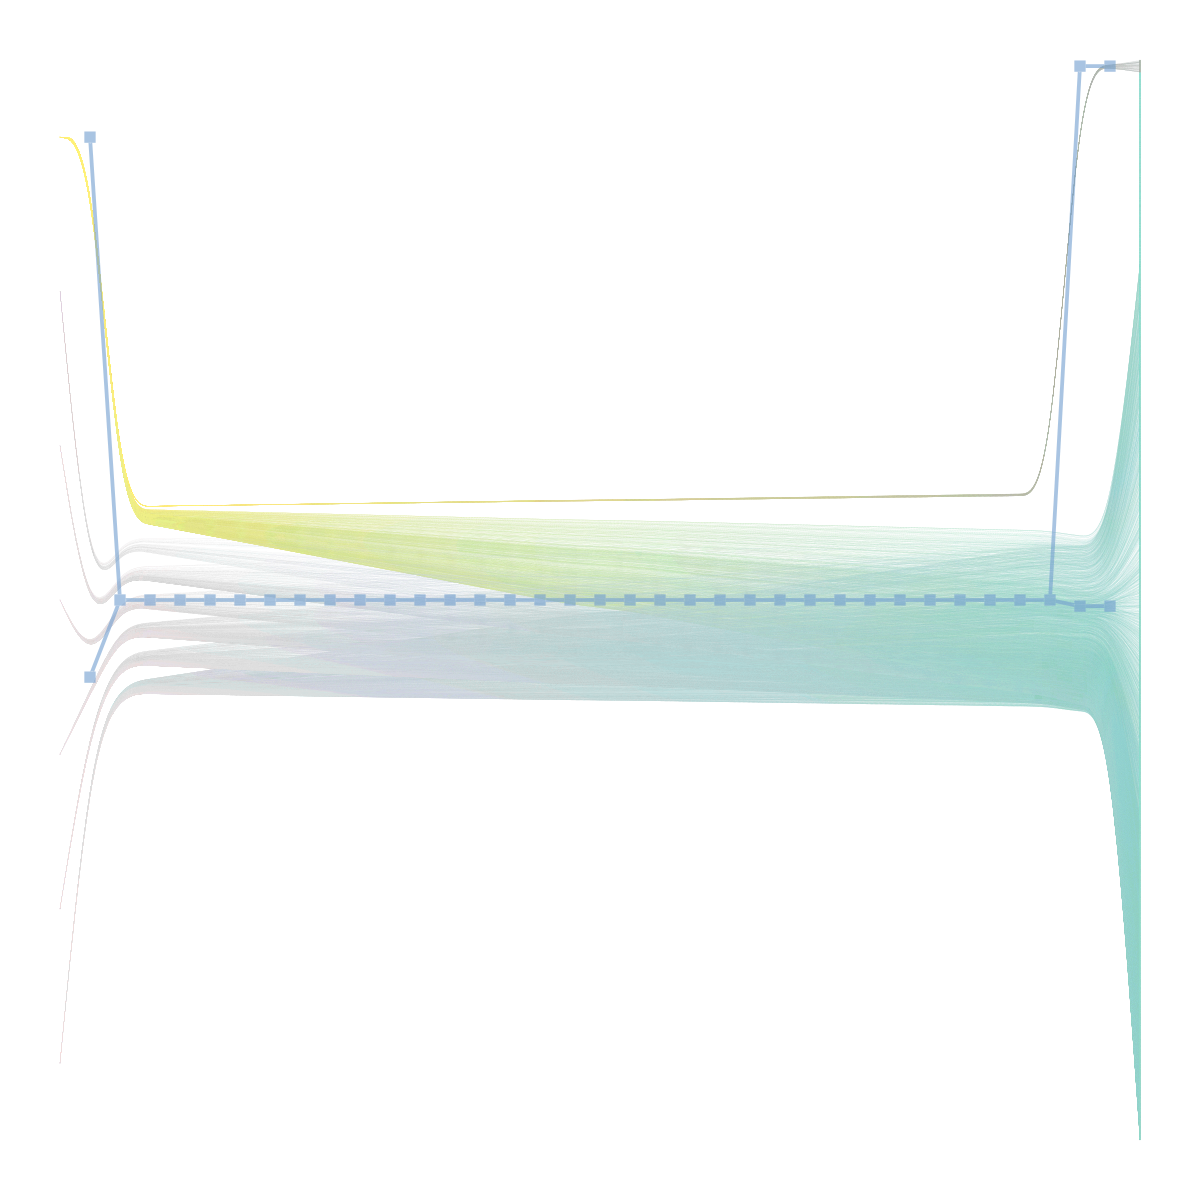

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f6018c5ed90, at 0x7f5ff1b71e20>,
 <GraphView object, directed, with 38462 vertices and 38461 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f60184b2bb0, at 0x7f6018434d90>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f60184b2bb0, at 0x7f5ff1b71190>, False), at 0x7f60184b2bb0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f60184b2bb0, at 0x7f603c177bb0>)

In [15]:
state_tmp.draw(layout="bipartite",subsample_edges=6000,bip_aspect=1, hvertex_size=8, hedge_pen_width=1.9, output_size=(600, 600))

In [44]:
len([i for i in state.get_clabel(l=0).a if i==11])

7